In [323]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Sample images

Retrieve five sample images from MNIST.

In [324]:
transform = transforms.Compose([transforms.ToTensor()])
criterion = CrossEntropyLoss()
set = MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(set, batch_size=5, shuffle=True)
mnist_images, labels = next(iter(loader))

Plot the images to show we have them.

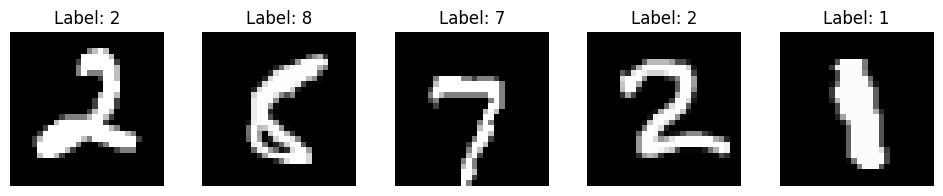

In [325]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
for i in range(5):
    axes[i].imshow(mnist_images[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

## Pret-trained model

Get a pretrained model for MNIST. Unbelievably there isn't one on the hub, so using one from the _adversarial-examples-pytorch_ repo.

In [326]:
class Basic_CNN(Module):
    def __init__(self, in_channels, num_classes):
        super(Basic_CNN, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv1_1 = Conv2d(self.in_channels, 32, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(32, 32, kernel_size=3, padding=1)

        self.maxpool1 = MaxPool2d(kernel_size=2)

        self.conv2_1 = Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(64, 64, kernel_size=3, padding=1)

        self.maxpool2 = MaxPool2d(kernel_size=2)

        self.fc1 = Linear(7*7*64, 200)
        self.fc2 = Linear(200, self.num_classes)


    def forward(self, x):

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))

        x = self.maxpool1(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))

        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Just load their saved parameters instead of doing a training loop.

In [327]:
mnist_model = Basic_CNN(1, 10)
saved = torch.load('9920.pth.tar', map_location='cpu')
mnist_model.load_state_dict(saved['state_dict'])
mnist_model.eval()

Basic_CNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

Show that the model can correctly classify the chosen examples.

In [328]:
for img in mnist_images:
    out = mnist_model(img.unsqueeze(0))
    pred = np.argmax(out.data.cpu().numpy())
    print('Prediction before attack: %s' %(pred))

Prediction before attack: 2
Prediction before attack: 6
Prediction before attack: 7
Prediction before attack: 2
Prediction before attack: 1


## Untargeted attack

Use `epsilon // alpha` for number of iterations... but there are various other ways to go here.

In [329]:
def calc_iters(epsilon, alpha):
    return epsilon // alpha

How to do the attack. Number of iterations is epsilon divided by alpha, so max perturbation will not exceed epsilon.

In [330]:
def untargeted_attack(image, label, epsilon, alpha):
    orig = image
    image = image.clone().detach().requires_grad_(True)
    conf_vecs = []
    pred_adv = None
    for _ in range(calc_iters(epsilon, alpha)):
        output = mnist_model(image)
        loss = criterion(output, label)
        loss.backward()

        perturbation = (alpha/255.0) * torch.sign(image.grad.data)
        perturbation = torch.clamp((image.data + perturbation) - orig, min=-epsilon/255.0, max=epsilon/255.0)
        image.data = orig + perturbation

        image.grad.data.zero_()

        confidences = mnist_model(image).data.numpy()
        norm_conf = np.exp(confidences)/np.sum(np.exp(confidences))
        conf_vecs.append(norm_conf[0])
        pred_adv = np.argmax(norm_conf)

    return image, conf_vecs, pred_adv

Demonstrate misclassifications using the attack.

In [331]:
epsilon = 20
alpha = 2

perturbed_images = []
confidences = []
preds = []
for i in range(5):
    image = mnist_images[i].unsqueeze(0)
    label = labels[i].unsqueeze(0)
    perturbed, confidence, pred = untargeted_attack(image, label, epsilon, alpha)
    perturbed_images.append(perturbed)
    confidences.append(confidence)
    preds.append(pred)

Show the perturbed images and their true / predicted classes.

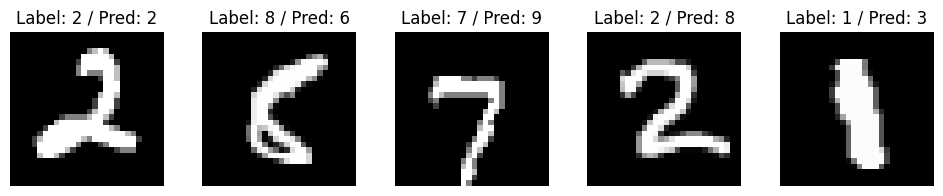

In [332]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
for i in range(5):
    axes[i].imshow(mnist_images[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()} / Pred: {preds[i]}")
    axes[i].axis('off')

plt.show()

Show the trajectories of the confidence vectors over the iterations.

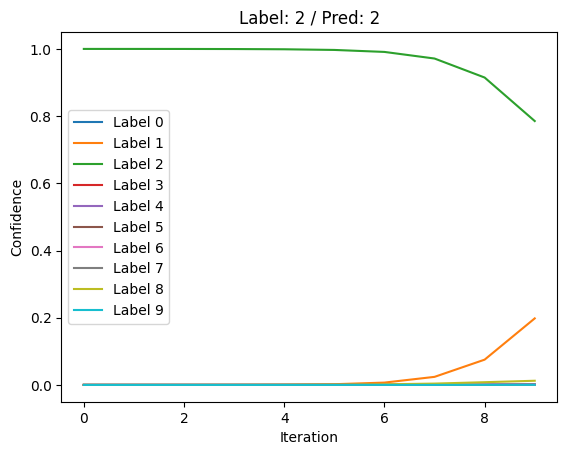

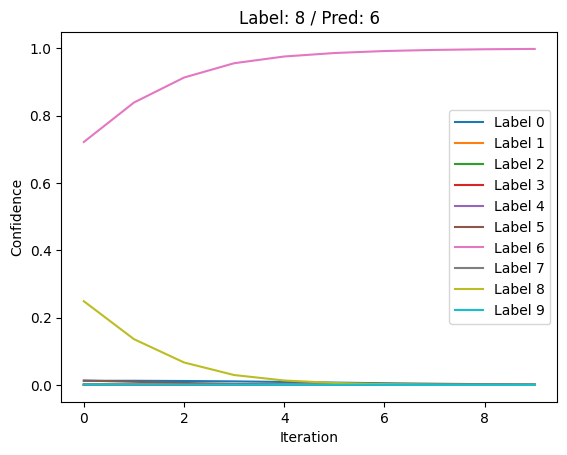

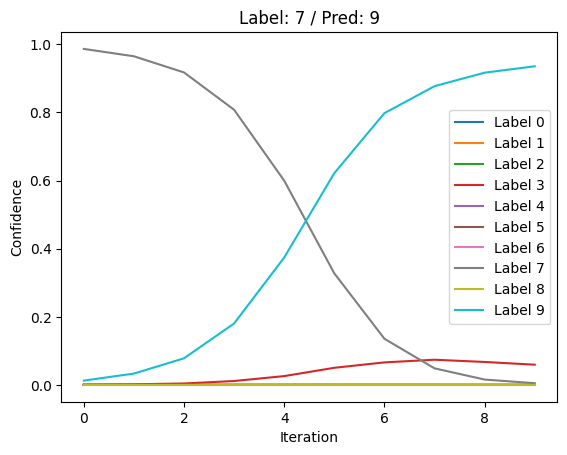

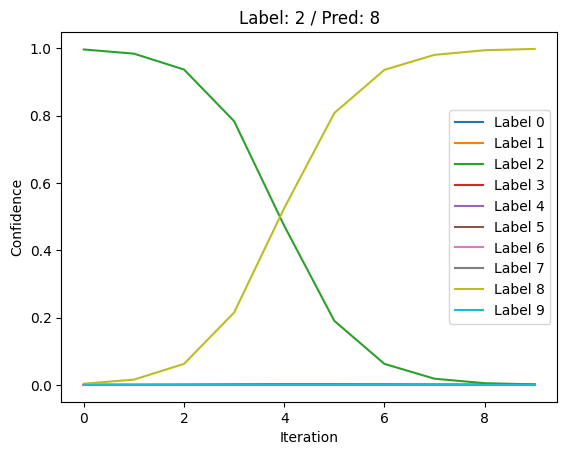

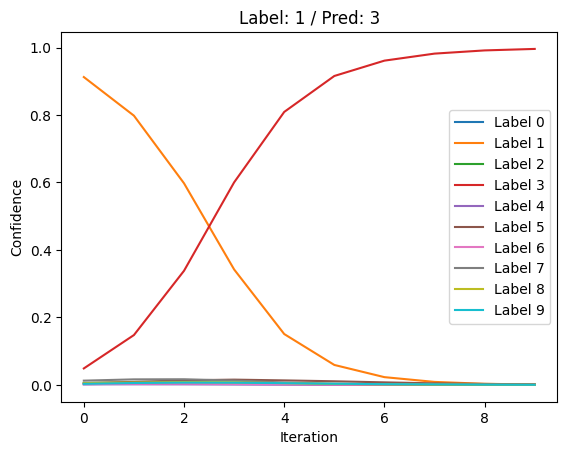

In [333]:
for i in range(5):
    for j in range(10):
        cfs = [confidences[i][k][j] for k in range(calc_iters(epsilon, alpha))]
        plt.plot(list(range(10)), cfs, label=f'Label {j}')

    plt.xlabel('Iteration')
    plt.ylabel('Confidence')
    plt.title(f"Label: {labels[i].item()} / Pred: {preds[i]}")
    plt.legend()
    plt.show()

Generate heatmaps for the examples for ranges of values for epsilon and alpha. The _heat_ is the model's confidence that the example's true label is the correct one.

In [334]:
epsilons = list(range(1, 40, 1))
alphas = list(range(1, 40, 1))

heats = []
for i in range(5):
    heat = []
    heats.append(heat)
    for e in epsilons:
        row = []
        heat.append(row)
        for a in alphas:
            if a > e:
                row.append(np.nan)
            else:
                image = mnist_images[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                perturbed, confidence, pred = untargeted_attack(image, label, e, a)
                row.append(confidence[-1][label])

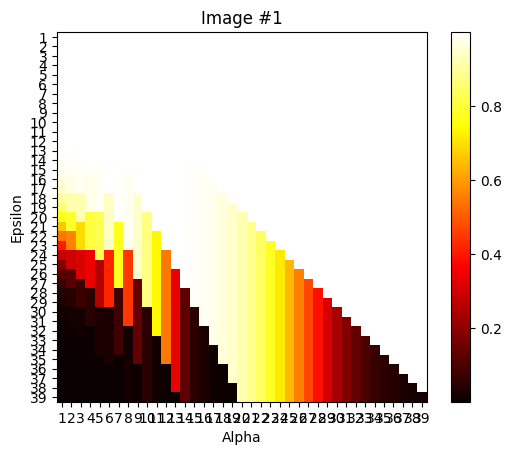

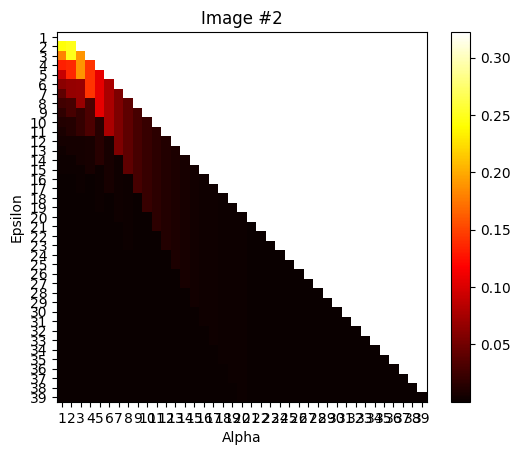

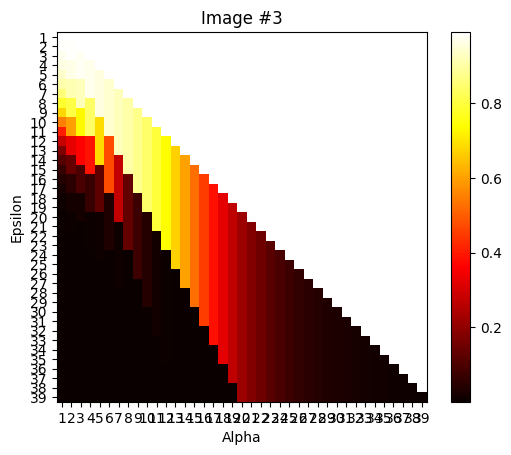

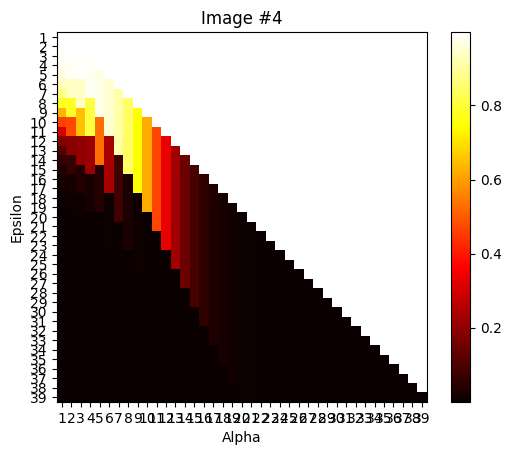

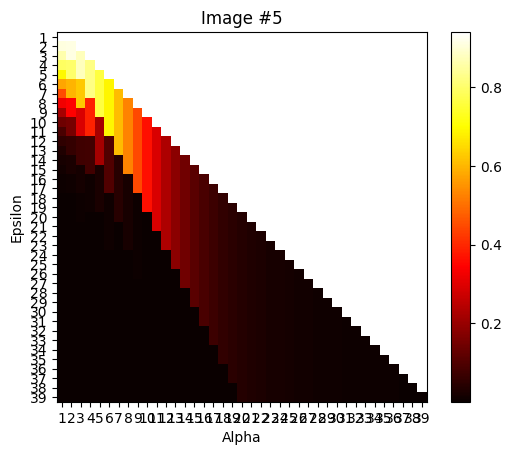

In [335]:
for i in range(5):
    plt.imshow(heats[i], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Alpha')
    plt.ylabel('Epsilon')
    plt.title(f'Image #{i + 1}')
    plt.xticks(ticks=np.arange(len(alphas)), labels=alphas)
    plt.yticks(ticks=np.arange(len(epsilons)), labels=epsilons)
    plt.show()